In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

from src.utils import *
from src.impedance import *
from src.datatype import MRIDataset, iUSDataset
from src.renderer import *
from src.cone import *
from src.impedance import ImpedanceEstimator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.cluster import KMeans
import cv2

print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

2.7.1+cu126
CUDA available: True
CUDA version: 12.6
GPU name: NVIDIA GeForce GTX 1650


In [3]:
patient_id = "003" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"

# Load with nibabel; each img is a Nifti1Image object
us_img = nib.load(str(image_path / iUS_file))
t1_img = nib.load(str(image_path / t1_file))
t2_img = nib.load(str(image_path / t2_file))

# Extract data arrays (as NumPy) and affines
US_vol = us_img.get_fdata(dtype=np.float32)
US_affine = us_img.affine
T1_vol = t1_img.get_fdata(dtype=np.float32)
T1_affine = t1_img.affine
T2_vol = t2_img.get_fdata(dtype=np.float32)
T2_affine = t2_img.affine

In [4]:
ct_path = PROJECT_ROOT / 'additional_data' / 'CT_scan'
aligned_path = PROJECT_ROOT / 'additional_data' / 'Vivek_prostate_aligned_mri_us'
vivek_ct = "vivek_volume.nii.gz"
noe_ct = "CT2_1.1_Routine_Brain_19950903173032_2.nii.gz"
aligned_mri = "mr000000_registered.nii.gz"
aligned_us = "us000000.nii.gz"

vivek_ct_img = nib.load(str(ct_path / vivek_ct))
vivek_ct_vol = vivek_ct_img.get_fdata(dtype=np.float32)
vivek_ct_affine = vivek_ct_img.affine
noe_ct_img = nib.load(str(ct_path / noe_ct))
noe_ct_vol = noe_ct_img.get_fdata(dtype=np.float32)
noe_ct_affine = noe_ct_img.affine
aligned_mri_img = nib.load(str(aligned_path / aligned_mri))
aligned_mri_vol = aligned_mri_img.get_fdata(dtype=np.float32)
aligned_mri_affine = aligned_mri_img.affine
aligned_us_img = nib.load(str(aligned_path / aligned_us))
aligned_us_vol = aligned_us_img.get_fdata(dtype=np.float32)
aligned_us_affine = aligned_us_img.affine

In [63]:
print(vivek_ct_img.header)
print(np.min(noe_ct_vol), np.max(noe_ct_vol), np.mean(noe_ct_vol))

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 201 201 239   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.  1.5 1.5 1.5 0.  0.  0.  0. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -150.70508
qoffset_y       : 4.294922
qoffset_z       : 734.9
srow_x          : [   1.5       

# Brain, Noé DICOM file conveted to NIfTI

In [132]:
opening_angle = 0.9157579425453843

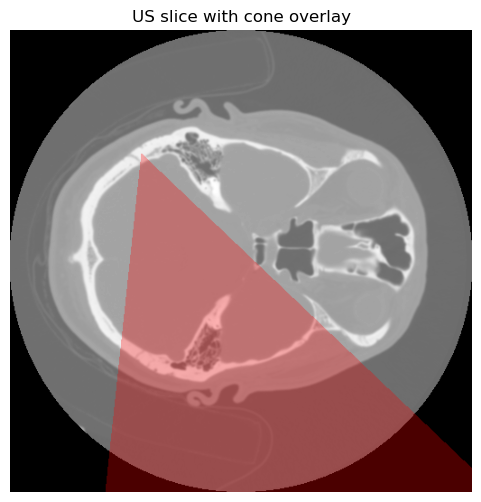

In [ ]:
slice = 100
x0, y0 = 140, 360
direction_vec_2d = direction_vec = np.array([ 0.34467694, -0.93872137])
mask_ct = overlay_cone(noe_ct_vol[:,:,slice], apex=np.array([x0, y0]), direction_vector=direction_vec_2d, opening_angle=opening_angle)
plot_overlay_cone(noe_ct_vol[:,:,slice], mask_ct)

In [ ]:
start = 0
n_rays = 64
dx, dy = direction_vec_2d
direction_vec = np.array([dx, dy, slice])
source = np.array([x0, y0, slice])
directions = generate_cone_directions(direction_vec, opening_angle, n_rays)


In [ ]:
# Z = (1000 + noe_ct_vol ) * 1540
Z_noe = 1000 * (1540 + 0.35 * noe_ct_vol) + noe_ct_vol * (1540 + 0.35 * noe_ct_vol)

In [ ]:
renderer = UltrasoundRenderer(num_samples=228, attenuation_coeff=0.0001)
x,z,intensities = renderer.plot_beam_frame(
            volume=torch.tensor(Z_noe),
            source=torch.tensor(source),
            directions=torch.tensor(directions),
            angle=0,
            plot=False,
            artifacts=False,
            start=start
        )

C:\Users\g630d\AppData\Local\Temp\ipykernel_23184\1497929538.py:5: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



[INFO] Tracing rays with source: tensor([140, 360, 100], dtype=torch.int32) and directions shape: torch.Size([64, 1, 3])


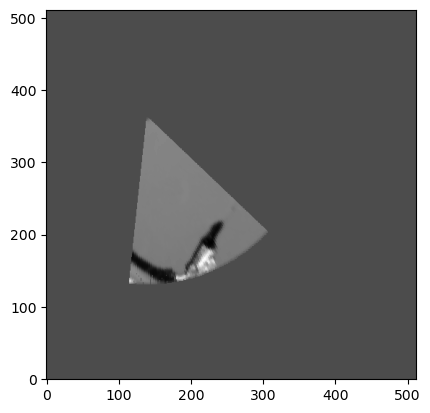

In [92]:
H, W = noe_ct_vol[:,:,slice].shape[:2]
synth_img = differentiable_splat(x, z, intensities, H=H, W=W, sigma=0.5)
plt.imshow(synth_img, cmap='gray', origin="lower")

# Chest, vivek volume

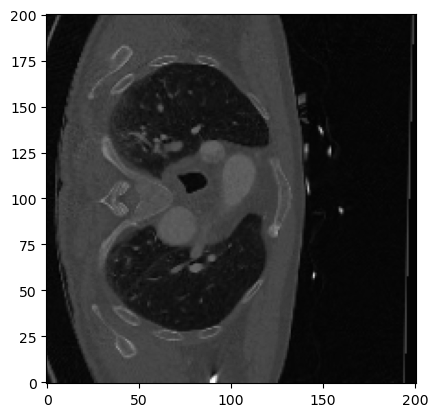

In [ ]:
plt.imshow(vivek_ct_vol[:,:,1], cmap='gray', origin="lower")

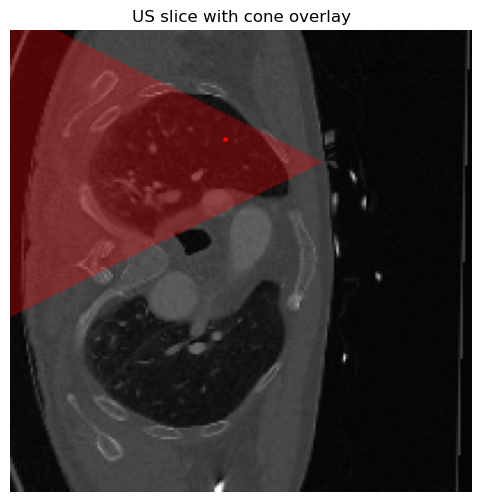

In [131]:
slice = 1
x0, y0 = 136,143
direction_vec_2d = np.array([ -1, 0])
mask_ct = overlay_cone(vivek_ct_vol[:,:,slice], apex=np.array([x0, y0]), direction_vector=direction_vec_2d, opening_angle=opening_angle)
plot_overlay_cone(vivek_ct_vol[:,:,slice], mask_ct)
plt.plot(93, 153, 'r.', markersize=5)

In [ ]:
start = 0
n_rays = 200
dx, dy = direction_vec_2d
direction_vec = np.array([dx, dy, slice])
source = np.array([x0, y0, slice])
directions = generate_cone_directions(direction_vec, opening_angle, n_rays)


In [114]:
Z_vivek = 1000 * (1540 + 0.35 * vivek_ct_vol) + vivek_ct_vol * (1540 + 0.35 * vivek_ct_vol)

In [129]:
Z_vivek[93,153,1]

8674.625

In [122]:
renderer = UltrasoundRenderer(num_samples=100, attenuation_coeff=0.0001)
x,z,intensities = renderer.plot_beam_frame(
            volume=torch.tensor(Z_vivek),
            source=torch.tensor(source),
            directions=torch.tensor(directions),
            angle=0,
            plot=False,
            artifacts=False,
            start=start
        )

C:\Users\g630d\AppData\Local\Temp\ipykernel_23184\2421764054.py:5: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



[INFO] Tracing rays with source: tensor([136, 143,   1], dtype=torch.int32) and directions shape: torch.Size([200, 1, 3])


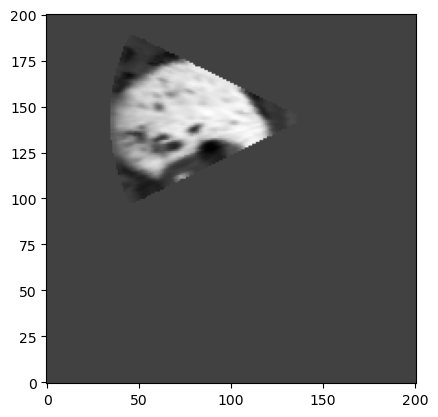

In [123]:
H, W = vivek_ct_vol[:,:,slice].shape[:2]
synth_img = differentiable_splat(x, z, intensities, H=H, W=W, sigma=0.5)
plt.imshow(synth_img, cmap='gray', origin="lower")

Looks like there is some issue here...

# Train MLP to find Z_vol (Acoustic Impedance)

In [13]:
def generate_cone_directions(direction_mri_world, opening_angle, n_rays):
    """
    Generate a fan of directions centered on direction_mri_world,
    spanning opening_angle (in radians), in the (x, y) plane (z=0).
    Returns: (n_rays, 3) tensor
    """
    # Normalize the median direction
    d = np.array(direction_mri_world[:2])
    d = d / np.linalg.norm(d)
    # Orthogonal vector in-plane
    ortho = np.array([-d[1], d[0]])
    # Angles from -half to +half opening
    angles = np.linspace(-opening_angle/2, opening_angle/2, n_rays)
    directions = []
    for a in angles:
        v = np.cos(a) * d + np.sin(a) * ortho
        directions.append([v[0], v[1], 0.0])
    return torch.tensor(directions, dtype=torch.float32)

In [14]:
n_rays = 64
source = torch.tensor(apex_mri_world)
directions = generate_cone_directions(direction_mri_world, opening_angle, n_rays)

us_real = us_slice
cone_mask = mask_segment_us

directions = generate_cone_directions(direction_mri_world, opening_angle, n_rays)
print(source, directions, np.degrees(opening_angle))

tensor([ 68.1002, 290.1414, 130.0000], dtype=torch.float64) tensor([[-0.1058, -0.9944,  0.0000],
        [-0.0913, -0.9958,  0.0000],
        [-0.0768, -0.9970,  0.0000],
        [-0.0623, -0.9981,  0.0000],
        [-0.0478, -0.9989,  0.0000],
        [-0.0333, -0.9994,  0.0000],
        [-0.0188, -0.9998,  0.0000],
        [-0.0042, -1.0000,  0.0000],
        [ 0.0103, -0.9999,  0.0000],
        [ 0.0248, -0.9997,  0.0000],
        [ 0.0394, -0.9992,  0.0000],
        [ 0.0539, -0.9985,  0.0000],
        [ 0.0684, -0.9977,  0.0000],
        [ 0.0829, -0.9966,  0.0000],
        [ 0.0974, -0.9952,  0.0000],
        [ 0.1118, -0.9937,  0.0000],
        [ 0.1263, -0.9920,  0.0000],
        [ 0.1407, -0.9901,  0.0000],
        [ 0.1550, -0.9879,  0.0000],
        [ 0.1694, -0.9856,  0.0000],
        [ 0.1837, -0.9830,  0.0000],
        [ 0.1980, -0.9802,  0.0000],
        [ 0.2122, -0.9772,  0.0000],
        [ 0.2264, -0.9740,  0.0000],
        [ 0.2405, -0.9707,  0.0000],
        [ 0.254

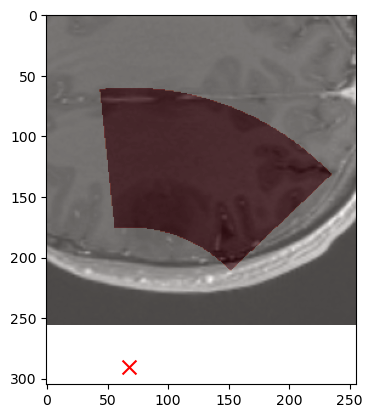

In [15]:
plt.imshow(T1_vol[:, :, 130], cmap='gray')
plt.imshow(mask_segment_mri, cmap='Reds', alpha=0.3)
plt.scatter(
    apex_mri_world[0], 
    apex_mri_world[1], 
    c='red', s=100, label='Apex', marker='x'
)


# REMASTERED 2

In [16]:
device = torch.device('cpu')
print(device)

cpu


In [17]:
class ImpedanceLearner(nn.Module):
    """Learning the mapping MRI -> Acoustic Impedance"""
    def __init__(self, input_dim=1, hidden_dims=[32, 32]):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], 1)
        )
        self.mlp.to(device)
        self.to(device)  # in your model's __init__ or before training
    
    def forward(self, x):
        x = x.to(device)
        original_shape = x.shape
        x_flat = x.reshape(-1, 1)
        out_flat = self.mlp(x_flat)
        return out_flat.reshape(original_shape)

    
    def training_forward(self, 
                         renderer:UltrasoundRenderer,
                         x:torch.Tensor,
                         source:torch.Tensor,
                         directions:torch.Tensor,
                         angle:float,
                         start:float=0.4):
        """
        Forward pass for training, returns impedance values.
        x: T1_vol
        """
        # assuming that training plane direction is [:,:, fixed slice]
        # x_flat = x[:, :, slice_idx].reshape(-1, 1)  # Flatten the slice
        # Z_vol  = self.mlp(x_flat).view_as(x[:, :, slice_idx]).unsqueeze(2)  # Reshape to match the original slice shape
        x = x.to(device)
        source = source.to(device)
        directions = directions.to(device)

        x_slice = x[:, :, slice_idx]
        print(x_slice.device, x_slice.shape)
        Z_slice = self.forward(x_slice).to(device)
        print(Z_slice.device, Z_slice.shape)
        Z_vol = x.clone()
        Z_vol[:, :, slice_idx] = Z_slice
        print(Z_vol.device)

        # Z_vol = self.forward(x).to(device)

        # remder the synthetic ultrasound
        x,z,intensities = renderer.plot_beam_frame(
            volume=Z_vol, # issue here, this SHOULD NOT BE DETACHED THAT IS THE WHOLE POINT
            source=source,
            directions=directions,
            angle=angle,
            plot=False,
            artifacts=False,
            start=start
        )

        # returned the x, z coordinates and intensities, relative to the apex
        # Note pour gabi: x and z are in the same coordinate system as the source, with an up vector pointing towards the median
        return x,z, intensities
       
class UltrasoundSynthesisModel:

    def __init__(self,
                 renderer:UltrasoundRenderer,
                 impedance_model:ImpedanceLearner,
                 us_real:torch.Tensor,
                 mask:torch.Tensor,
                 source:torch.Tensor,
                 directions:torch.Tensor,
                 angle:float=45.0,
                 ):
        """
        renderer: UltrasoundRenderer
        impedance_model: ImpedanceLearner
        us_real: Real ultrasound tensor (n_rays, depth)
        mask: (n_rays, depth)
        source: (3,)
        directions: (n_rays, 3)
        """
        self.renderer = renderer
        self.impedance_model = impedance_model.to(device)

        self.us_real            = torch.tensor(us_real).to(device)
        self.mask = torch.tensor(mask).to(device)
        self.source = source.to(device)
        self.directions = directions.to(device)
        self.angle = angle
        # Normalize the real ultrasound data
        self.real_min = us_real.min()
        self.real_max = us_real.max()
        self.us_real_norm = ((us_real - self.real_min) / (self.real_max - self.real_min + 1e-8))
        self.us_real_norm = torch.tensor(self.us_real_norm).to(device)
        self.impedance_model.train()
    
    def gradient_loss(self, a, b, mask):
        """Loss robust to edge artifacts"""
        a_grad = torch.abs(a[:, 1:] - a[:, :-1])
        b_grad = torch.abs(b[:, 1:] - b[:, :-1])
        return F.l1_loss(a_grad[mask[:, 1:]], b_grad[mask[:, 1:]])

    def loss(self, synth_us):
        """Compute the loss between synthetic and real ultrasound"""
        print(type(synth_us), type(self.us_real_norm))
        main_loss = F.mse_loss(synth_us[self.mask], self.us_real_norm[self.mask])
        edge_loss = self.gradient_loss(synth_us, self.us_real_norm, self.mask)
        return main_loss + 0.5 * edge_loss
    
    def train_step(self, t1_volume, optimizer):
        torch.cuda.empty_cache()
        print(torch.cuda.memory_allocated() / 1e6, 'MB allocated')
        print(torch.cuda.memory_reserved() / 1e6, 'MB reserved')
        
        # Forward pass through the model to get synthetic ultrasound
        
        x, z, synth_us_flat = self.impedance_model.training_forward(
            renderer=self.renderer,
            x=t1_volume,
            source=self.source,
            directions=self.directions,
            angle=self.angle,  # or pass as argument if variable
        )
        # x = x.detach()
        # z = z.detach()
        # Rasterize into a grid (shape must match self.mask and self.us_real)
        x = x.float()
        z = z.float()
        apex = torch.tensor(apex_mri_world[:2], dtype=torch.float32, device=x.device)
        median = torch.tensor([-0.3, -0.9], dtype=torch.float32, device=x.device)
        print(x.device, z.device, apex.device, median.device)
        
        x_rot, z_rot = rotate_around_apex(x, 
                                        z, 
                                        apex=apex,
                                        median=median)
        synth_img = differentiable_splat(x_rot.to(device), 
                                        z_rot.to(device), 
                                        synth_us_flat.to(device), 
                                        H=256, W=256, sigma=0.5)
        
        # Compute loss and backpropagate
        loss_value = self.loss(synth_img)
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        item = loss_value.item()

        del x, z, synth_us_flat, x_rot, z_rot, synth_img, loss_value
        torch.cuda.empty_cache()
        print(torch.cuda.memory_allocated() / 1e6, 'MB allocated')
        print(torch.cuda.memory_reserved() / 1e6, 'MB reserved')
        

        return item
        
    def train(self, t1_volume, optimizer, num_epochs=1000):
        """
        Train the impedance model on the T1 volume.
        """
        t1_volume = t1_volume.to(device)
        losses = []
        for epoch in range(num_epochs):
            loss_val = self.train_step(t1_volume, optimizer)
            losses.append(loss_val)
            print(f"Epoch {epoch:4d} | Loss: {loss_val:.6f}")
        return losses

In [18]:
model_one = ImpedanceLearner(1)
mask_one = mask_segment_us
renderer_one = UltrasoundRenderer(num_samples=228, attenuation_coeff=0.0001)
optimizer_one = torch.optim.Adam(model_one.parameters(), lr=0.001)  

USM = UltrasoundSynthesisModel(
    renderer=renderer_one,
    impedance_model=model_one,
    us_real=us_slice,
    mask=mask_segment_us,
    source=torch.tensor(apex_mri_world),
    directions=directions.flip(0),
    angle=np.degrees(opening_angle)/2
)


In [19]:
# USM.train(
#     t1_volume=torch.tensor(T1_vol, dtype=torch.float32),
#     optimizer=optimizer_one,
#     num_epochs=100
# )

In [20]:
# USM.train(
#     t1_volume=torch.tensor(T1_vol, dtype=torch.float32),
#     optimizer=optimizer_one
# )

## Plotting the results

The code below corrects the direction and orientation.

cpu torch.Size([256, 256])
cpu torch.Size([256, 256])
cpu
[INFO] Tracing rays with source: tensor([ 68.1002, 290.1414, 130.0000], dtype=torch.float64) and directions shape: torch.Size([64, 1, 3])
[INFO] Starting from sample index: 110 (for instance, to skip bones)
[INFO] Padded output to start from sample index: 110 torch.Size([64, 229])


C:\Users\g630d\AppData\Local\Temp\ipykernel_23184\2970305400.py:23: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\g630d\AppData\Local\Temp\ipykernel_23184\2970305400.py:24: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\g630d\AppData\Local\Temp\ipykernel_23184\2970305400.py:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



Recomputing Impedance Volume


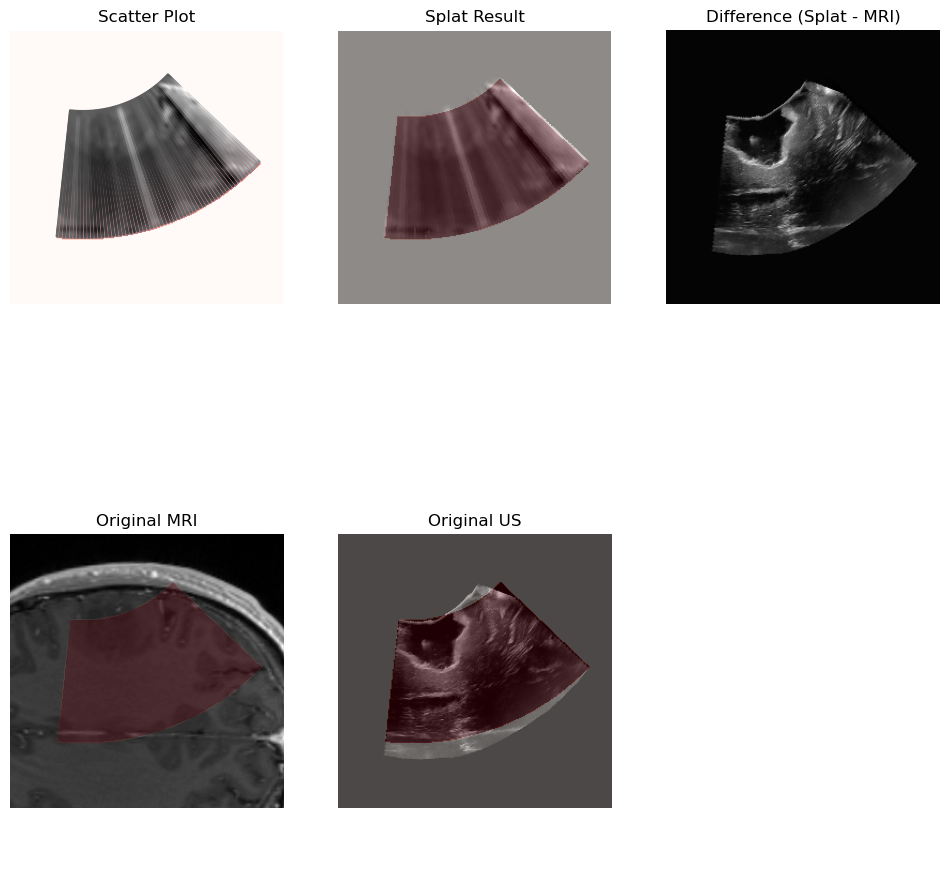

In [21]:
out_2 = model_one.training_forward(
    renderer=renderer_one,
    x=torch.Tensor(T1_vol),
    source=torch.tensor(apex_mri_world),
    directions=directions.flip(0),
    angle=np.degrees(opening_angle)/2,
    start=110
)

x,z, intensities = out_2
import torch

x = x.float().detach().cpu()
z = z.float().detach().cpu()
# apex = torch.tensor(apex_mri_world[:2], dtype=torch.float32)
# median = torch.tensor([-0.3, -0.9], dtype=torch.float32)
intensities = intensities.float().detach().cpu()

# x,z = rotate_around_apex(x, 
#                                   z, 
#                                   apex=apex,
#                                   median=median)
final_image = differentiable_splat(torch.tensor(x), 
                                   torch.tensor(z), 
                                   torch.tensor(intensities), H=256, W=256, sigma=0.5)
# Compare scatter to splat
fig, ax = plt.subplots(2, 3, figsize=(12, 12))

# Scatter Plot
ax[0, 0].scatter(x, z, c=intensities, s=1, cmap='gray')
ax[0, 0].imshow(mask_segment_mri, alpha=0.5, origin='lower', cmap='Reds')
ax[0, 0].set_facecolor('black')
ax[0, 0].set_title("Scatter Plot")
ax[0, 0].set_xlim(0, 256)
ax[0, 0].set_ylim(0, 256)

# Splat Result
ax[0, 1].imshow(final_image, cmap='gray', origin='lower')
ax[0, 1].imshow(mask_segment_mri, alpha=0.3, origin='lower', cmap='Reds')
ax[0, 1].set_title("Splat Result")
ax[0, 1].set_xlim(0, 256)
ax[0, 1].set_ylim(0, 256)

# Original MRI
ax[1, 0].imshow(t1_slice, cmap='gray', origin='lower')
ax[1, 0].imshow(mask_segment_mri, cmap='Reds', alpha=0.3 * (mask_segment_mri > 0).astype(float), origin='lower')
ax[1, 0].set_title("Original MRI")

# Original US
ax[1, 1].imshow(us_slice, cmap='gray', origin='lower')
ax[1, 1].imshow(mask_segment_us, cmap='Reds', alpha=0.3, origin='lower')
ax[1, 1].set_title("Original US")

# Difference
rel_diff = np.abs(final_image/(final_image.max()-final_image.min()) - us_slice/(us_slice.max()-us_slice.min()))
ax[0, 2].imshow(-final_image + us_slice, cmap='gray', origin='lower')
ax[0, 2].set_title("Difference (Splat - MRI)")

# Recomputed Impedance_Vol
print("Recomputing Impedance Volume")
# Z_vol = model_one.forward(torch.tensor(T1_vol, dtype=torch.float32)).detach().numpy()
for a in ax.flat:
    a.axis('off')
plt.show()

# del x, z, intensities, final_image, out_2
torch.cuda.empty_cache()

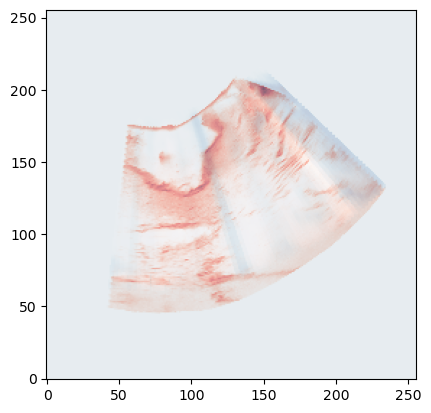

In [22]:
plt.imshow(final_image, origin='lower', cmap='Blues', alpha=0.5, )
plt.imshow(us_slice, origin='lower', cmap='Reds', alpha=0.5)

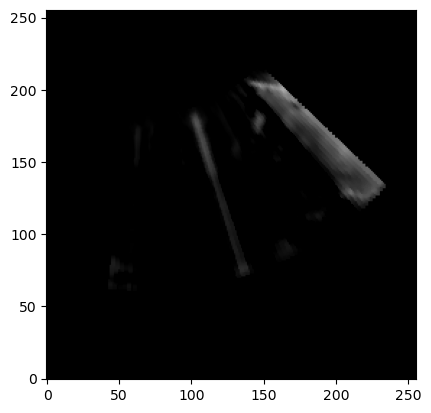

In [23]:
# out_2 = renderer.plot_beam_frame(
#     volume=torch.tensor(Z_vol),
#     source=source,
#     directions=directions,
#     angle=np.degrees(opening_angle)/2,
#     plot=False,
#     artifacts=False,
#     start=110
# )
# x,z = rotate_around_apex(out_2[0], 
#                         out_2[1], 
#                         apex=apex_mri_world[:2],
#                         median=[-0.3,-0.9])
img = differentiable_splat(x, z, out_2[2], H=256, W=256, sigma=0.5)
plt.imshow(img.detach().numpy(), cmap='gray', vmin=0, vmax=intensities.max()*1.5, origin='lower')


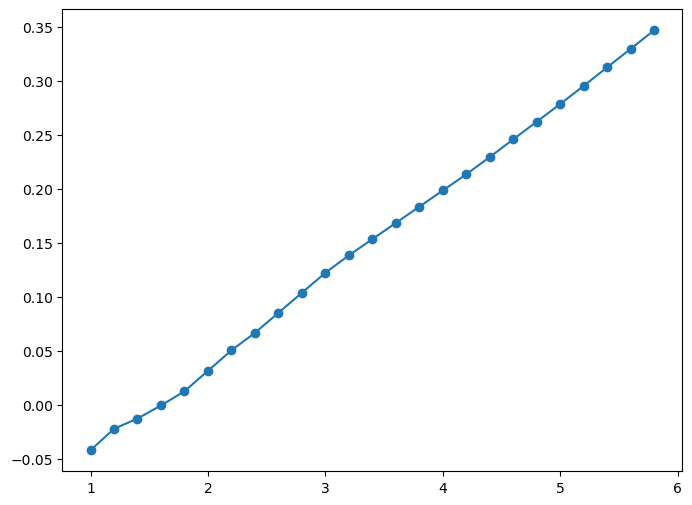

In [24]:
x = torch.arange(1, 6, step=0.2,dtype=torch.float32).reshape(-1, 1)
y = model_one.forward(x).detach()

plt.figure(figsize=(8, 6))
plt.plot(x.numpy(), y, marker='o', label='Predicted Impedance')